# Sentiment Analysis and Topic Modeling on Tweets about Online Education during COVID-19

## Importing Libraries

In [ ]:
 !pip install pyLDAvis
 !pip install vaderSentiment

In [ ]:
## Base and cleaning
import pandas as pd
import numpy as np
import nltk
import string
import re

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

## Natural language Processing(NLP)
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk import word_tokenize, pos_tag
import pprint
from pprint import pprint
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import warnings
warnings.filterwarnings('ignore')


## Loading the Dataset

In [ ]:
f=pd.read_csv('onlinelearning_cleaned_data_latest.csv')


In [ ]:
f.columns


Index(['Unnamed: 0', 'ID', 'Date', 'Tweet'], dtype='object')

In [ ]:
copy=f.copy()

In [ ]:
Time=[]
for index,date in enumerate(copy.Date):
    collect=(str(date)).split()
    copy.at[index,'Date']=collect[0]
    Time.append(collect[1])

In [ ]:
copy["Time"]=Time

In [ ]:
copy.head()

,Unnamed: 0,ID,Date,Tweet,Time
0,2,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!...",23:42:55+00:00
1,41,1454485143037546497,2021-10-30,each week and then pass over to the children T...,16:27:35+00:00
2,42,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?,16:14:48+00:00
3,86,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ...",12:50:50+00:00
4,89,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...,12:44:47+00:00


In [ ]:
copy=copy.drop(columns=['Unnamed: 0', 'Time'])

In [ ]:
copy.head()

,ID,Date,Tweet
0,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!..."
1,1454485143037546497,2021-10-30,each week and then pass over to the children T...
2,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?
3,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ..."
4,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...


In [ ]:
print(len(copy))
print(len(f))

28091
28091


In [ ]:
copy.Tweet

0        All Green STARS on ! Every lesson, every unit!...
1        each week and then pass over to the children T...
2            Why did you consider a profession of teacher?
3        Read from ALL sources Remember, the test will ...
4        Answer ALL questions There is no negative mark...
                               ...                        
28086    Into the world of remote online Learning due t...
28087    Many teachers in Ontario are using asynchronou...
28088    Closed b/c of COVID-19? Check out FB group "In...
28089            So agree with you. It’s all about journey
28090    Calsouthern let's you start your courses anyti...
Name: Tweet, Length: 28091, dtype: object

In [ ]:
copy=copy.dropna()

## Textblob Sentiment Analysis

In [ ]:
TextBlob_Polarity=[]
TextBlob_Sentiment=[]
for post in copy.Tweet:
    blob=TextBlob(post)
    polarity=blob.sentiment.polarity
    TextBlob_Polarity.append(polarity)
    if polarity > 0:
        TextBlob_Sentiment.append("pos")
    elif polarity < 0:
        TextBlob_Sentiment.append("neg")
    else:
        TextBlob_Sentiment.append("neu")   

In [ ]:
copy["TextBlob_Polarity"]=TextBlob_Polarity
copy["TextBlob_Sentiment"]=TextBlob_Sentiment

In [ ]:
copy.head()

,ID,Date,Tweet,TextBlob_Polarity,TextBlob_Sentiment
0,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!...",-0.390625,neg
1,1454485143037546497,2021-10-30,each week and then pass over to the children T...,0.800000,pos
2,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?,0.000000,neu
3,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ...",0.000000,neu
4,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...,0.012500,pos


## Vader Sentiment analysis

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media
In Vader sentiment analysis, we use a dictionary that maps words to a score from -4 to 4 (-4 is most negative). Even emotions are mapped: e.g. /-: and 0:-3 get mapped to  -1.3 and 1.5. The sentence sentiment is then normalized sum of the sentiments from each word to keep it from -1 to 1. Therefore, in this part, we will use Tweet instead of Clean_tweet
The VADER library returns 4 values:
- pos: The probability of the sentiment to be positive
- neu: The probability of the sentiment to be neutral
- neg: The probability of the sentiment to be negative
- compound: The normalized compound score which calculates the sum of all lexicon ratings and takes values from -1 to 1

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if we want a single unidimensional measure of sentiment for a given sentence. It is also useful for us because we want to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values are:
- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer=SentimentIntensityAnalyzer()

Vader_sentiment= []
for post in copy.Tweet:
    scores=analyzer.polarity_scores(post)
    if scores['compound']>=0.05:
        Vader_sentiment.append("pos")
    elif scores['compound']<= -0.05:
        Vader_sentiment.append("neg")
    else: 
        Vader_sentiment.append("neu")
        
#CITE: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. 
#Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [ ]:
#Add Vader sentiment to copy
copy["Vader_Sentiment"]=Vader_sentiment
copy.head()   

,ID,Date,Tweet,TextBlob_Polarity,TextBlob_Sentiment,Vader_Sentiment
0,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!...",-0.390625,neg,neu
1,1454485143037546497,2021-10-30,each week and then pass over to the children T...,0.800000,pos,pos
2,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?,0.000000,neu,neu
3,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ...",0.000000,neu,pos
4,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...,0.012500,pos,neg


## Sentiment Analysis Visualization

In [ ]:
TextBlob_Sentiment= copy.TextBlob_Sentiment.value_counts() #(normalize=True)
Vader_Sentiment= copy.Vader_Sentiment.value_counts()
print(TextBlob_Sentiment)
print(Vader_Sentiment)

pos    16519
neu     8009
neg     3555
Name: TextBlob_Sentiment, dtype: int64
pos    18402
neu     5799
neg     3882
Name: Vader_Sentiment, dtype: int64


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=TextBlob_Sentiment.index.tolist(), values=TextBlob_Sentiment.iloc[:].tolist(), name="TextBlob Sentiment"),
              1, 1)
fig.add_trace(go.Pie(labels=Vader_Sentiment.index.tolist(), values=Vader_Sentiment.iloc[:].tolist(), name="Vader Sentiment"),
              1, 2)

# Use 'hole' to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Sentiment Analysis Visualization",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Textblob', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Vader', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()

## Time Series

In [ ]:
copy = copy.reset_index(drop=True)

In [ ]:
copy.head()

,ID,Date,Tweet,TextBlob_Polarity,TextBlob_Sentiment,Vader_Sentiment
0,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!...",-0.390625,neg,neu
1,1454485143037546497,2021-10-30,each week and then pass over to the children T...,0.800000,pos,pos
2,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?,0.000000,neu,neu
3,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ...",0.000000,neu,pos
4,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...,0.012500,pos,neg


In [ ]:
#Time Series Data Extraction
observation=[]
percentage_of_pos_rev=[]
percentage_of_neg_rev=[]
percentage_of_neu_rev=[]
m=0
y=0
p=0
neg_r=0
neu_r=0
for i in range(len(copy)):
    split_date=copy.Date[i].split('-')
    year=split_date[0]
    month=split_date[1]
    day=split_date[2]
    if m != month or y !=year:
        if p!=0:
            percentage_of_pos_rev.append(round(p/total,2))
        if neg_r != 0:
            percentage_of_neg_rev.append(round(neg_r/total,2))
        if neu_r != 0:
            percentage_of_neu_rev.append(round(neu_r/total,2))
        p=0
        neg_r= 0
        neu_r= 0
        m=month
        y=year
        observation.append("/".join([m, y]))
        if copy.TextBlob_Sentiment[i]=="pos":
            p+=1
        if copy.TextBlob_Sentiment[i]=="neg":
            neg_r+=1  
        if copy.TextBlob_Sentiment[i]=="neu":
            neu_r+=1        
        total=1   
    
    elif m == month and y ==year:   
        total+=1    
        if copy.TextBlob_Sentiment[i]=="pos":
            p+=1   
        if copy.TextBlob_Sentiment[i]=="neg":
            neg_r+=1  
        if copy.TextBlob_Sentiment[i]=="neu":
            neu_r+=1            
    if i== (len(copy)-1):
        percentage_of_pos_rev.append(round(p/total,2))
        percentage_of_neg_rev.append(round(neg_r/total,2))
        percentage_of_neu_rev.append(round(neu_r/total,2))

        

In [ ]:
print((observation))
print(percentage_of_pos_rev)
print(percentage_of_neg_rev)
print(percentage_of_neu_rev)


['10/2021', '09/2021', '08/2021', '07/2021', '06/2021', '05/2021', '04/2021', '03/2021', '02/2021', '01/2021', '12/2020', '11/2020', '10/2020', '09/2020', '08/2020', '07/2020', '06/2020', '05/2020', '04/2020', '03/2020']
[0.56, 0.6, 0.59, 0.61, 0.48, 0.55, 0.61, 0.57, 0.49, 0.52, 0.43, 0.53, 0.59, 0.62, 0.62, 0.61, 0.59, 0.6, 0.62, 0.65]
[0.13, 0.11, 0.14, 0.09, 0.09, 0.09, 0.14, 0.14, 0.13, 0.12, 0.09, 0.11, 0.14, 0.14, 0.13, 0.12, 0.14, 0.14, 0.14, 0.13]
[0.31, 0.29, 0.26, 0.3, 0.42, 0.36, 0.25, 0.3, 0.38, 0.36, 0.48, 0.36, 0.27, 0.24, 0.24, 0.28, 0.27, 0.26, 0.24, 0.22]


In [ ]:
observation.reverse()
percentage_of_pos_rev.reverse()
percentage_of_neg_rev.reverse()
percentage_of_neu_rev.reverse()

In [ ]:
print(observation)
print(percentage_of_pos_rev)
print(percentage_of_neg_rev)
print(percentage_of_neu_rev)

['03/2020', '04/2020', '05/2020', '06/2020', '07/2020', '08/2020', '09/2020', '10/2020', '11/2020', '12/2020', '01/2021', '02/2021', '03/2021', '04/2021', '05/2021', '06/2021', '07/2021', '08/2021', '09/2021', '10/2021']
[0.65, 0.62, 0.6, 0.59, 0.61, 0.62, 0.62, 0.59, 0.53, 0.43, 0.52, 0.49, 0.57, 0.61, 0.55, 0.48, 0.61, 0.59, 0.6, 0.56]
[0.13, 0.14, 0.14, 0.14, 0.12, 0.13, 0.14, 0.14, 0.11, 0.09, 0.12, 0.13, 0.14, 0.14, 0.09, 0.09, 0.09, 0.14, 0.11, 0.13]
[0.22, 0.24, 0.26, 0.27, 0.28, 0.24, 0.24, 0.27, 0.36, 0.48, 0.36, 0.38, 0.3, 0.25, 0.36, 0.42, 0.3, 0.26, 0.29, 0.31]


In [ ]:
time_series=pd.DataFrame({"Date":observation, "Per_pos":percentage_of_pos_rev, "Per_neg":percentage_of_neg_rev,"Per_neu":percentage_of_neu_rev})

In [ ]:
time_series.to_csv("TimeSeries.csv", index=False)

In [ ]:
#Upload corona.csv for the number of monthly corona cases worldwide
corona =pd.read_csv("corona.csv")
corona.head()

,Date,Cases,New_cases
0,3/2020,1482877,1396855
1,4/2020,3281736,1798859
2,5/2020,6188463,2906727
3,6/2020,10458098,4269635
4,7/2020,17603582,7145484


In [ ]:
time_series.head()

,Date,Per_pos,Per_neg,Per_neu
0,03/2020,0.65,0.13,0.22
1,04/2020,0.62,0.14,0.24
2,05/2020,0.60,0.14,0.26
3,06/2020,0.59,0.14,0.27
4,07/2020,0.61,0.12,0.28


In [ ]:
time_series.describe()

,Per_pos,Per_neg,Per_neu
count,20.000000,20.000000,20.000000
mean,0.572000,0.123000,0.304500
std,0.056345,0.019494,0.068401
min,0.430000,0.090000,0.220000
25%,0.545000,0.110000,0.257500
50%,0.590000,0.130000,0.285000
75%,0.610000,0.140000,0.360000
max,0.650000,0.140000,0.480000


#### Plot time series and corona cases

In [ ]:
#plot time series and corona

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=3)

fig.add_trace(
    go.Scatter(x=time_series['Date'], y=time_series['Per_pos']), row=1, col=1, )
#fig.add_trace(
#    go.Scatter(x= corona['Date'], y= corona['Cases']), row=1, col=2, )
fig.add_trace(
    go.Scatter(x= corona['Date'], y= corona['New_cases']), row=1, col=3)
 
# Update xaxis properties
fig.update_xaxes(title_text="Percentage of Positive Tweets", row=1, col=1)
#fig.update_xaxes(title_text="Cumulative Corona Cases", row=1, col=2)
fig.update_xaxes(title_text="Monthly Corona Cases", row=1, col=3)

fig.update_layout(title_text="Positive Tweets Versus Monthly Corona Cases")
fig.show()


In [ ]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=time_series['Date'], y=time_series['Per_neg']), row=1, col=1, )
fig.add_trace(
    go.Scatter(x= corona['Date'], y= corona['New_cases']), row=1, col=2)
 
# Update xaxis properties
fig.update_xaxes(title_text="Percentage of Negative Tweets", row=1, col=1)
fig.update_xaxes(title_text="Monthly Corona Cases", row=1, col=2)

fig.update_layout(title_text="Negative Tweets Versus Corona Cases")
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=time_series['Date'], y=time_series['Per_neu']), row=1, col=1, )
fig.add_trace(
    go.Scatter(x= corona['Date'], y= corona['New_cases']), row=1, col=2)
 
# Update xaxis properties
fig.update_xaxes(title_text="Percentage of Neutral Tweets", row=1, col=1)
fig.update_xaxes(title_text="Monthly Corona Cases", row=1, col=2)

fig.update_layout(title_text="Neutral Tweets Versus Corona Cases")
fig.show()

#### Decomposition models for Time Series Analysis (only for positive reviews)

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

An additive model suggests that the components are added together as follows:

y(t) = Level + Trend + Seasonality + Noise

Multiplicative Model
A multiplicative model suggests that the components are multiplied together as follows:

y(t) = Level * Trend * Seasonality * Noise

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
df = pd.read_csv('TimeSeries.csv', parse_dates=['Date'], index_col='Date')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['Per_pos'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['Per_pos'], model='additive', extrapolate_trend='freq')

Extract numerical output of the trend, seasonal and residual components in the result_mul and put it in a dataframe.


In [ ]:
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed1 = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed1.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed1.head()

,seas,trend,resid,actual_values
Date,,,,
2020-03-01,1.064007,0.591086,1.033518,0.65
2020-04-01,1.080448,0.587381,0.976940,0.62
2020-05-01,1.018641,0.583676,1.009156,0.60
2020-06-01,0.951825,0.579970,1.068782,0.59
2020-07-01,1.097035,0.576265,0.964910,0.61


Extract numerical output of the trend, seasonal and residual components in the result_add and put it in a dataframe.

In [ ]:
#The numerical output of the trend, seasonal and residual components are stored in the result_mul output itself. Let’s extract them and put it in a dataframe.

# Actual Values = Product of (Seasonal + Trend + Resid)
df_reconstructed2 = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed2.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed2.head()

,seas,trend,resid,actual_values
Date,,,,
2020-03-01,0.037469,0.591086,0.021445,0.65
2020-04-01,0.045363,0.587381,-0.012744,0.62
2020-05-01,0.010735,0.583676,0.005589,0.60
2020-06-01,-0.025559,0.579970,0.035589,0.59
2020-07-01,0.053146,0.576265,-0.019411,0.61


Plot Multiplicative Decompose and Additive Decompose

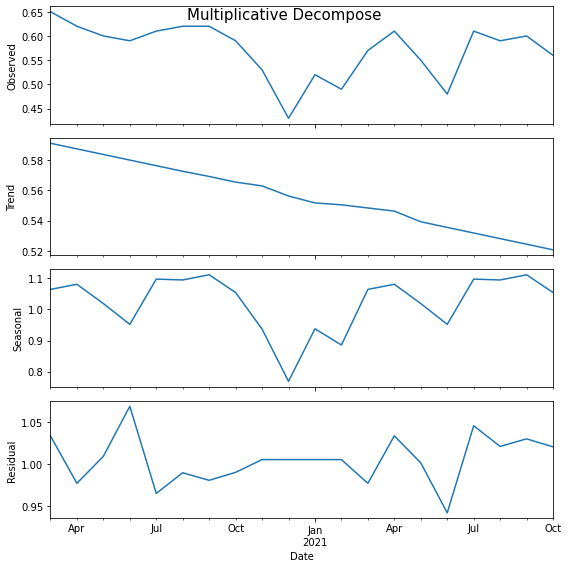

In [ ]:
plt.rcParams.update({'figure.figsize': (8,8)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=15)
plt.show()

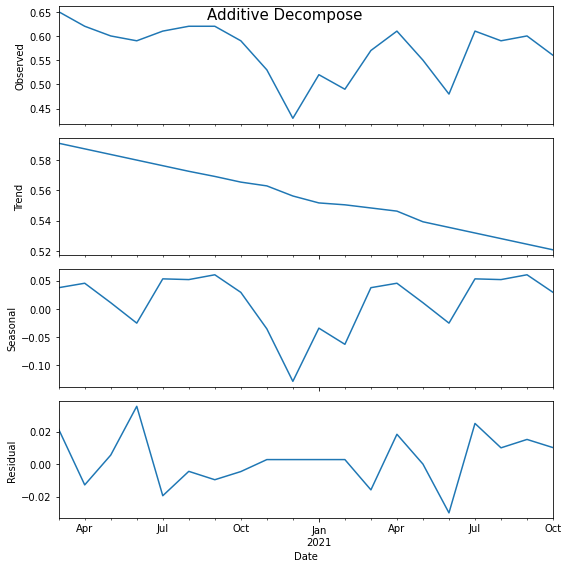

In [ ]:
result_add.plot().suptitle('Additive Decompose', fontsize=15)
plt.show()

The trend of pos comment is downward and there is no seasonality

Test for seasonality of the % pos time series

(0.0, 12.0)

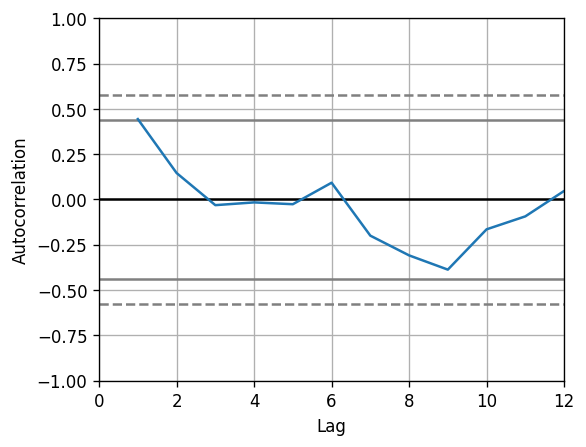

In [ ]:
from pandas.plotting import autocorrelation_plot
# Draw Plot
plt.rcParams.update({'figure.figsize':(5,4), 'figure.dpi':120})
autocorrelation_plot(time_series.Per_pos.tolist()).set_xlim([0, 12])

## Topic Modeling with LDA for positive tweets

Using Machine learning (Gensim-Latent Dirichlet Allocation) to explore the most important topics discussed within the dataset.


## PreProcessing Data

In any machine learning task, cleaning the data is as important as model building if not more. And when it comes to unstructured data like text, this process is even more important.

To this end , I will perform some cleansing activities as pre-processing steps beforehand model building:

Lowercase text
Remove stop words and punctuations
Once our data does not contain any unwanted characters, we will perform Lemmatization to reduce inflected words to their root words.

In [ ]:
## Use gensims simple_preprocess(), set deacc=True to remove punctuations.

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) #deacc=True removes punctuations

data_words = list(sent_to_words(list(copy['Tweet'])))
print(data_words[:1])

[['all', 'green', 'stars', 'on', 'every', 'lesson', 'every', 'unit', 'going', 'for', 'that']]


### Creating Bigrams and Trigrams

Bigrams are 2 words frequently occuring together in docuent. Trigrams are 3 words frequently occuring


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

['each', 'week', 'and', 'then', 'pass', 'over', 'to', 'the', 'children', 'they', 'take', 'turns', 'to', 'talk', 'about', 'what', 'they', 'are', 'reading', 'and', 'make', 'recommendations', 'it', 'great', 'way', 'to', 'engage', 'using', 'online', 'learning', 'just', 'wondering', 'what', 'do', 'you', 'do']


### Remove Stopwords, make bigrams and lemmatize

Using lemmatization instead of stemming is a practice which especially pays off in topic modeling because lemmatized words tend to be more human-readable than stemming.

In [ ]:
## Prepare stopwords

stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['online','student','class','learning','amp','school','teacher','time','course','day','today','need','u','teaching','go','week','no','thing','make','get', 'well', 'much', 'really', 'many', 'use', 'let', 'student', 'look', 'people', 'even', 'also', 'go', 'try', 'see', 'know', 'help'])

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

### Call the functions in order

In [ ]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
nlp = spacy.load(("en_core_web_sm"), disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_lemmatized)

copy['clean_tweet'] = data_words_nostops
copy.head()

,ID,Date,Tweet,TextBlob_Polarity,TextBlob_Sentiment,Vader_Sentiment,clean_tweet
0,1454594698614562821,2021-10-30,"All Green STARS on ! Every lesson, every unit!...",-0.390625,neg,neu,"[green, star, lesson, unit]"
1,1454485143037546497,2021-10-30,each week and then pass over to the children T...,0.800000,pos,pos,"[pass, child, take, turn, talk, read, recommen..."
2,1454481924928389123,2021-10-30,Why did you consider a profession of teacher?,0.000000,neu,neu,"[consider, profession]"
3,1454430596613099520,2021-10-30,"Read from ALL sources Remember, the test will ...",0.000000,neu,pos,"[read, source, remember, test, text, various, ..."
4,1454429071580930048,2021-10-30,Answer ALL questions There is no negative mark...,0.012500,pos,neg,"[answer, question, negative, marking, sure, at..."


## Exploratory Data Analysis

### Tweet Lengths

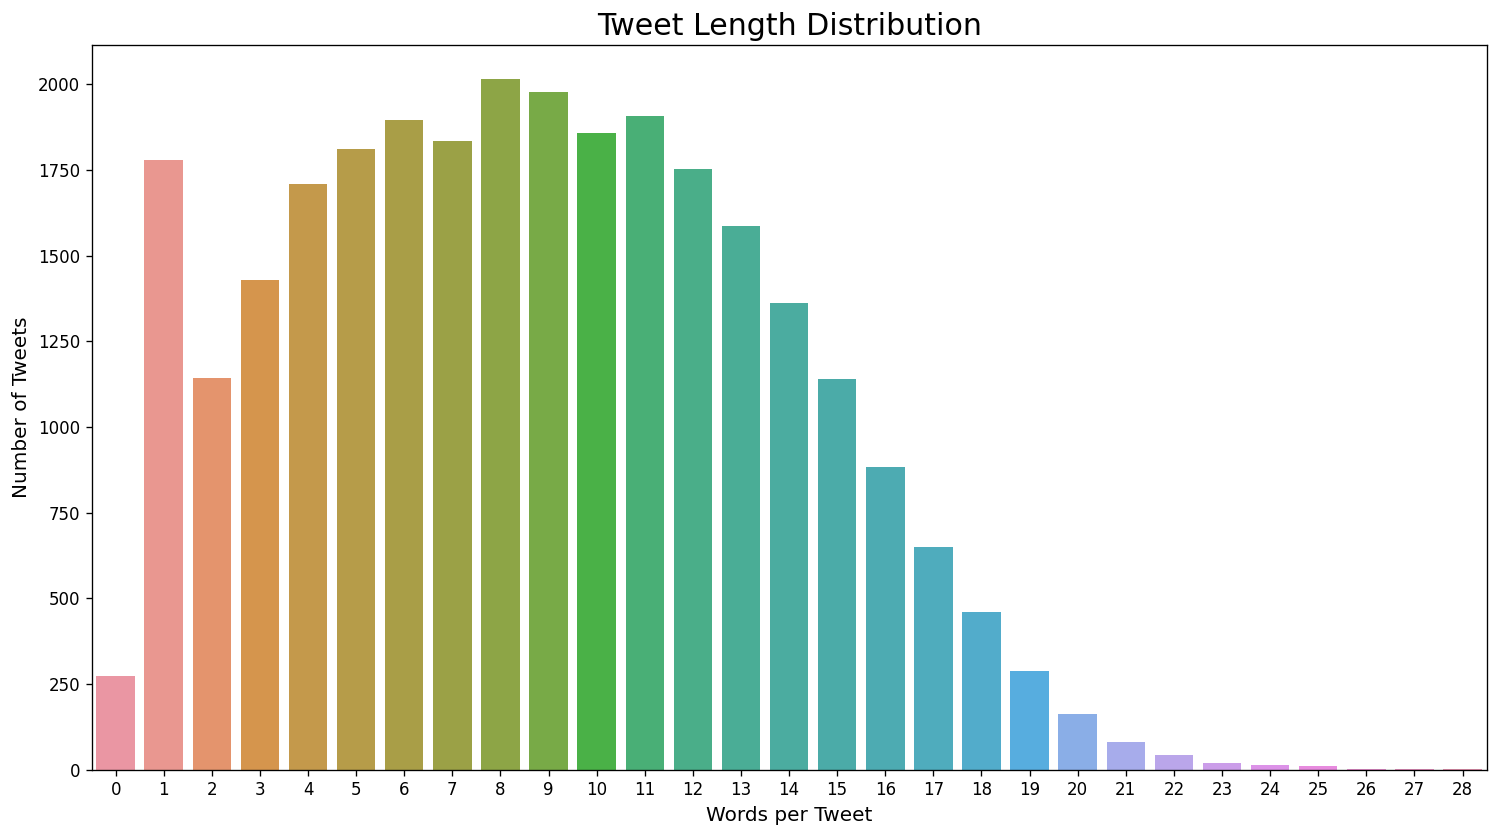

In [ ]:
tweet_lengths = [len(tokens) for tokens in copy['clean_tweet']]
plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

In [ ]:
## Removing records where clean_tweets = 0; i.e original tweet doesn't have any noun,verb, adjective or adverb.
copy = (copy[copy['clean_tweet'].apply(lambda x: len(x) != 0)])

### Wordcloud

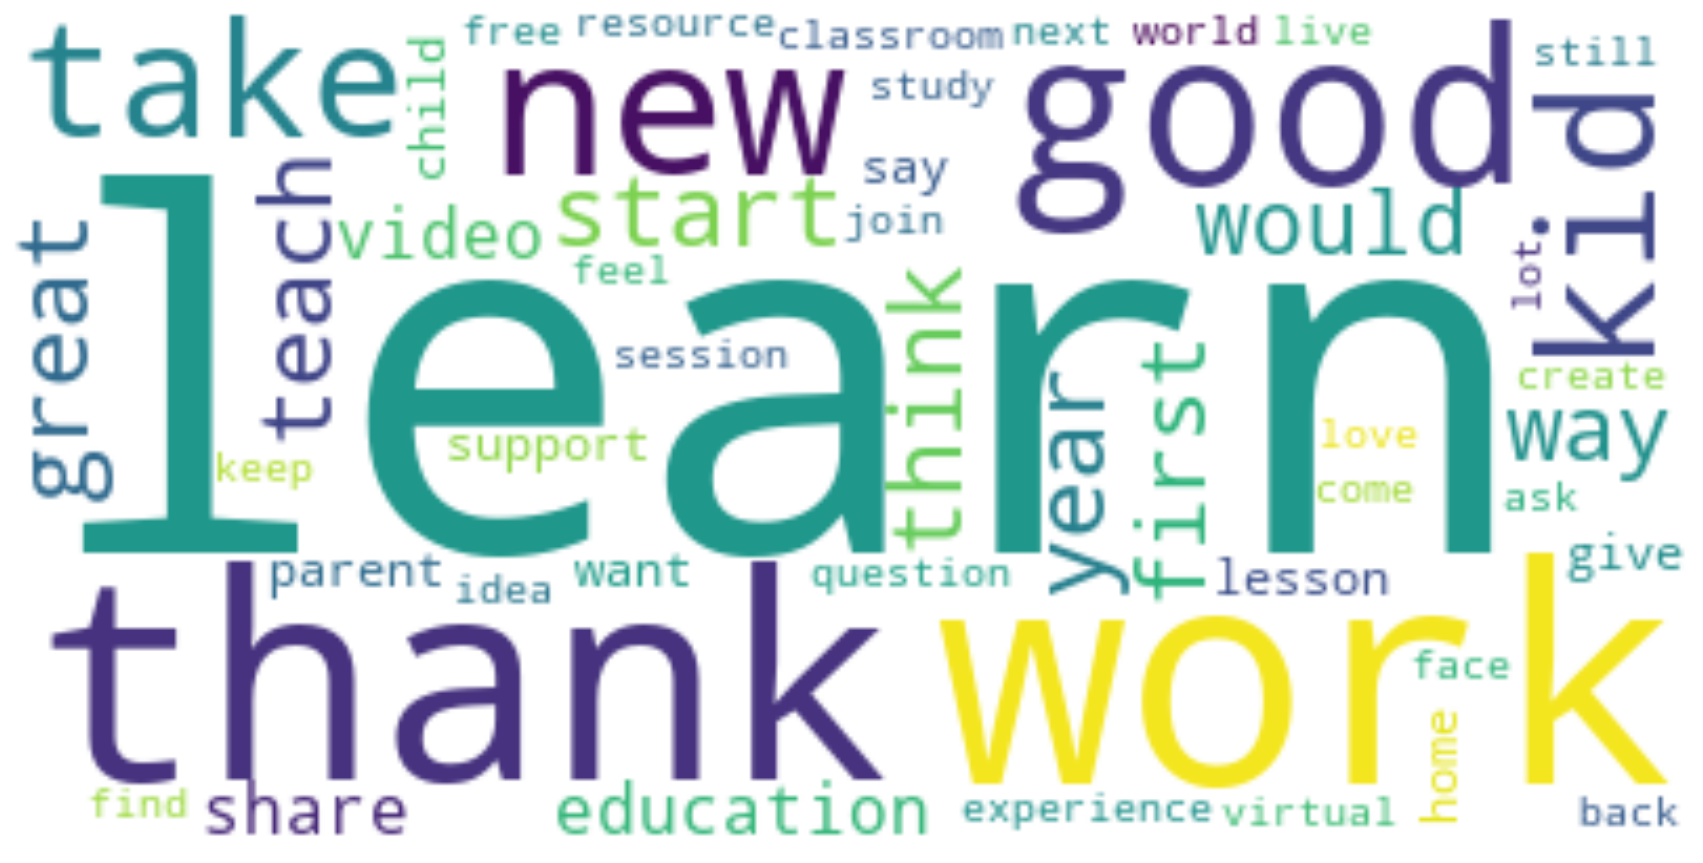

In [ ]:
#iterate through each tweet, then each token in each tweet, and store in one list
flat_words = [item for sublist in copy['clean_tweet'] for item in sublist]

word_freq = FreqDist(flat_words)

#retrieve word and count from FreqDist tuples

most_common_count = [x[1] for x in word_freq.most_common(50)]
most_common_word = [x[0] for x in word_freq.most_common(50)]

#create dictionary mapping of word count
top_50_dictionary = dict(zip(most_common_word, most_common_count))

#Create Word Cloud of top 50 words
# round_mask = np.array(Image.open( "rhombus.png"))
wordcloud = WordCloud(max_font_size=120, background_color = 'white', mask = None)\
.generate_from_frequencies(top_50_dictionary)

#plot with matplotlib
plt.figure(figsize=(14, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_50_cloud.png')

plt.show()

## Running LDA - Positive Tweets

In [ ]:
copy_positive = copy.loc[copy['TextBlob_Sentiment'] == 'pos']

## Create Dictionary and Corpus needed for Topic Modeling

In [ ]:
# Create Dictionary 
id2word_pos = gensim.corpora.Dictionary(copy_positive['clean_tweet'])  
# Create Corpus 
texts_pos = copy_positive['clean_tweet'] 
# Term Document Frequency 
corpus_pos = [id2word_pos.doc2bow(text) for text in texts_pos]  
# View 
print(corpus_pos[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


Gensim creates unique id for each word in the document. Its mapping of word_id and word_frequency. Example: (2,1) above indicates, word_id 2 occurs once in the document and so on.

This is used as input to LDA model.

Readable format of corpus can be obtained by executing below code block.

In [ ]:
[[(id2word_pos[id], freq) for id, freq in cp] for cp in corpus_pos[:1]]

[[('child', 1),
  ('engage', 1),
  ('great', 1),
  ('learn', 1),
  ('pass', 1),
  ('read', 1),
  ('recommendation', 1),
  ('take', 1),
  ('talk', 1),
  ('turn', 1),
  ('way', 1),
  ('wonder', 1)]]

## Building topic model

Parameters of LDA
Alpha and Beta are Hyperparameters — alpha represents document-topic density and Beta represents topic-word density, chunksize is the number of documents to be used in each training chunk, update_every determines how often the model parameters should be updated and passes is the total number of training passes.

A measure for best number of topics really depends on kind of corpus we are using, the size of corpus, number of topics you expect to see.

In [ ]:
lda_model_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
                                           id2word=id2word_pos,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the keyword of topics
print(lda_model_pos.print_topics())
doc_lda = lda_model_pos[corpus_pos]

[(0, '0.028*"learn" + 0.027*"work" + 0.021*"good" + 0.017*"share" + 0.017*"great" + 0.017*"teach" + 0.013*"new" + 0.013*"free" + 0.012*"support" + 0.012*"think"'), (1, '0.020*"first" + 0.017*"home" + 0.016*"would" + 0.016*"thank" + 0.013*"kid" + 0.013*"experience" + 0.012*"lesson" + 0.011*"right" + 0.010*"live" + 0.010*"year"'), (2, '0.021*"resource" + 0.020*"video" + 0.016*"move" + 0.013*"take" + 0.012*"love" + 0.011*"plan" + 0.011*"feel" + 0.011*"access" + 0.011*"face" + 0.009*"lecture"')]


We can see the top keywords and weights associated with keywords contributing to topic.

Topics are words with highest probability in topic and the numbers are the probabilities of words appearing in topic distribution.

But looking at keywords we cannot guess what the topic is!!

## Evaluate topic models

### Compute model Perplexity and Coherence score
Coherence score and perplexity provide a convinent way to measure how good a given topic model is.

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_pos.log_perplexity(corpus_pos))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_pos, texts=copy_positive['clean_tweet'], dictionary=id2word_pos, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.922034964507771

Coherence Score:  0.1667541792988733


- Lower the perplexity better the model.
- Higher the topic coherence, the topic is more human interpretable.


## Optimum Number of Topics

In [ ]:
def compute_coherence_values_pos(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values_pos = []
    model_list_pos = []
    for num_topics in range(start, limit, step):
#         print(num_topics)
        model_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
                                           id2word=id2word_pos,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list_pos.append(model_pos)
        coherencemodel_pos = CoherenceModel(model=model_pos, texts=texts, dictionary=dictionary, coherence='c_v')
#         print(coherencemodel_pos.get_coherence())
        coherence_values_pos.append(coherencemodel_pos.get_coherence())

    return model_list_pos, coherence_values_pos

In [ ]:
## Caution!!!
### This code might take 15-20 minutes to run

model_list_pos, coherence_values_pos = compute_coherence_values_pos(dictionary=id2word_pos, corpus=corpus_pos, texts=copy_positive['clean_tweet'], start=2, limit=10, step=1)

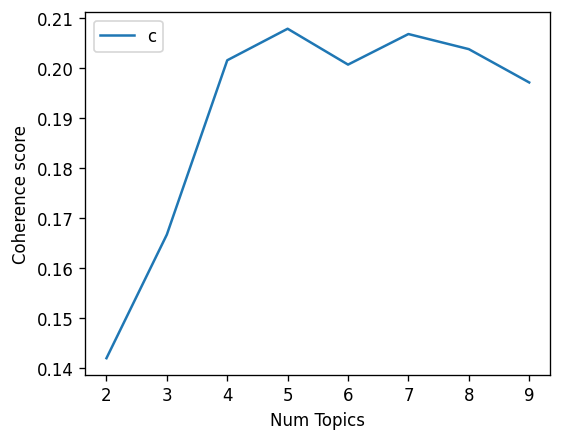

In [ ]:
limit=10; start=2; step=1
x= range(start, limit, step)

plt.plot(x, coherence_values_pos)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Visualize the topic model

In [ ]:
# Select the model and print the topics
optimal_model_pos = model_list_pos[3]
model_topics = optimal_model_pos.show_topics(formatted=False)

In [ ]:
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(optimal_model_pos, corpus_pos, id2word_pos)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.380174 -0.035723       1        1  28.506915
0      0.136235 -0.343831       2        1  22.678200
1      0.099843  0.184667       3        1  19.569448
2      0.084137  0.129793       4        1  16.529231
4      0.059959  0.065094       5        1  12.716205, topic_info=            Term         Freq        Total Category  logprob  loglift
3          learn  1919.000000  1919.000000  Default  30.0000  30.0000
162         work  1901.000000  1901.000000  Default  29.0000  29.0000
195     resource  1036.000000  1036.000000  Default  28.0000  28.0000
72          good  1452.000000  1452.000000  Default  27.0000  27.0000
74         teach  1121.000000  1121.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
570         link   147.133039   147.865553   Topic5  -4.9663   2.0573
270         lead   149.062143   149.804705   Topic5  -4.9533   2.0573
291  educational   139.998790   140.735959   Topic5  -5.0160   2.0570
28       develop   130.219581   130.949761   Topic5  -5.0884   2.0567
479        clear   131.072340   131.808476   Topic5  -5.0819   2.0567

[180 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
277       2  0.996802      able
50        2  0.999062    access
796       2  0.997587  activity
413       3  0.997195    advice
915       4  0.997628   already
...     ...       ...       ...
162       1  0.999769      work
503       3  0.998508     would
373       4  0.998469     write
473       3  0.998395      year
1857      1  0.996809      zoom

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3, 5])

Each bubble on the left-hand side represents topic. The larger the bubble, the more prevalent or dominant the topic is. Good topic model will be fairly big topics scattered in different quadrants rather than being clustered on one quadrant.

- The model with too many topics will have many overlaps, small sized bubbles clustered in one region of chart.
- If you move the cursor the different bubbles you can see different keywords associated with topics.

Here 3 topics are overlapping in one quadrant out of 5.

Let's check for 4 topics

In [ ]:
# Select the model and print the topics
optimal_model_pos = model_list_pos[2]
model_topics = optimal_model_pos.show_topics(formatted=False)

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(optimal_model_pos, corpus_pos, id2word_pos)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.364935  0.018556       1        1  35.305977
2     -0.140405  0.315171       2        1  22.706599
1     -0.119669 -0.167826       3        1  21.618077
0     -0.104860 -0.165901       4        1  20.369348, topic_info=           Term         Freq        Total Category  logprob  loglift
3         learn  1970.000000  1970.000000  Default  30.0000  30.0000
162        work  1835.000000  1835.000000  Default  29.0000  29.0000
195    resource  1060.000000  1060.000000  Default  28.0000  28.0000
72         good  1401.000000  1401.000000  Default  27.0000  27.0000
632        free   895.000000   895.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
310       focus   209.883948   210.608766   Topic4  -5.0822   1.5877
152        real   205.365936   206.083246   Topic4  -5.1040   1.5877
150    practice   198.520548   199.239675   Topic4  -5.1379   1.5875
557  suggestion   201.172878   201.913160   Topic4  -5.1246   1.5875
931       grade   188.593938   189.301706   Topic4  -5.1892   1.5874

[150 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
277       4  0.997322      able
50        3  0.999009    access
796       4  0.998737  activity
413       2  0.998201    advice
915       2  0.998057   already
...     ...       ...       ...
162       1  0.999418      work
49        3  0.999003     world
503       1  0.999240     would
473       3  0.999493      year
1857      2  0.997726      zoom

[120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

Here 2 topics are overlapping in one quadrant out of 4.
Let's check for 3 topics

In [ ]:
# Select the model and print the topics
optimal_model_pos = model_list_pos[1]
model_topics = optimal_model_pos.show_topics(formatted=False)

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(optimal_model_pos, corpus_pos, id2word_pos)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.316776 -0.037129       1        1  40.275668
2      0.191638 -0.246734       2        1  30.161675
1      0.125138  0.283863       3        1  29.562657, topic_info=          Term         Freq        Total Category  logprob  loglift
3        learn  1905.000000  1905.000000  Default  30.0000  30.0000
162       work  1837.000000  1837.000000  Default  29.0000  29.0000
195   resource  1065.000000  1065.000000  Default  28.0000  28.0000
72        good  1403.000000  1403.000000  Default  27.0000  27.0000
117      first   991.000000   991.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
417      close   295.851199   296.805012   Topic3  -5.1114   1.2154
413     advice   274.496393   275.374157   Topic3  -5.1863   1.2155
1062    remote   245.088913   245.876114   Topic3  -5.2997   1.2155
263        put   245.465674   246.261702   Topic3  -5.2981   1.2154
130      thank   773.234184  1083.706624   Topic3  -4.1507   0.8811

[132 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
50        2  0.997816   access
413       3  0.995010   advice
915       2  0.996835  already
558       2  0.998641  amazing
477       1  0.997340      ask
...     ...       ...      ...
162       1  0.999713     work
49        3  0.998045    world
503       3  0.999106    would
473       3  0.998529     year
1857      3  0.999084     zoom

[106 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

Here all the topics are spread across the quadrants
We'll be proceeding with 3 topics.

## Finding the dominant topic in each sentence

To find that, we find the topic number that has the highest percentage contribution in that document.

In [ ]:
def format_topics_values(ldamodel=optimal_model_pos, corpus=corpus_pos, texts=list(copy_positive['Tweet'])):
    value_topics_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list 
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                value_topics_df = value_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    value_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']             
    contents = pd.Series(texts)
    value_topics_df = pd.concat([value_topics_df, contents], axis=1)
    return(value_topics_df)    

df_topic_keywords_pos = format_topics_values(ldamodel=optimal_model_pos, corpus=corpus_pos, texts=list(copy_positive['Tweet']))

df_dominant_topic_pos = df_topic_keywords_pos.reset_index()
df_dominant_topic_pos.columns = ['Document_No','Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_pos.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.3961,"resource, video, move, take, love, plan, feel,...",each week and then pass over to the children T...
1,1,0.0,0.5168,"learn, work, good, share, great, teach, new, f...",Answer ALL questions There is no negative mark...
2,2,1.0,0.3751,"first, home, would, thank, kid, experience, le...",The ability to converse in another language is...
3,3,0.0,0.3778,"learn, work, good, share, great, teach, new, f...",Lots of students in Discord this semester. The...
4,4,0.0,0.3827,"learn, work, good, share, great, teach, new, f...",_74 Takes on a whole new meaning in the world ...


## Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. 

In [ ]:
# Group top 40 sentences under each topic
topics_sorteddf_pos = pd.DataFrame()

topics_outdf_grpd = df_topic_keywords_pos.groupby('Dominant_Topic')

for i, grp in topics_outdf_grpd:
    topics_sorteddf_pos = pd.concat([topics_sorteddf_pos, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(40)], 
                                            axis=0)

# Reset Index    
topics_sorteddf_pos.reset_index(drop=True, inplace=True)

# Format
topics_sorteddf_pos.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
topics_sorteddf_pos.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5786,"learn, work, good, share, great, teach, new, f...","""All the growth in higher education, however, ..."
1,0.0,0.5433,"learn, work, good, share, great, teach, new, f...",As an avid reader of nonfiction books the best...
2,0.0,0.5407,"learn, work, good, share, great, teach, new, f...","Having worked in adult mental health services,..."
3,0.0,0.5407,"learn, work, good, share, great, teach, new, f...","Having worked in adult mental health services,..."
4,0.0,0.5390,"learn, work, good, share, great, teach, new, f...",Tweets like this are EXTREMELY hurtful to the ...


## Word Clouds of Top N Keywords in Each Topic

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

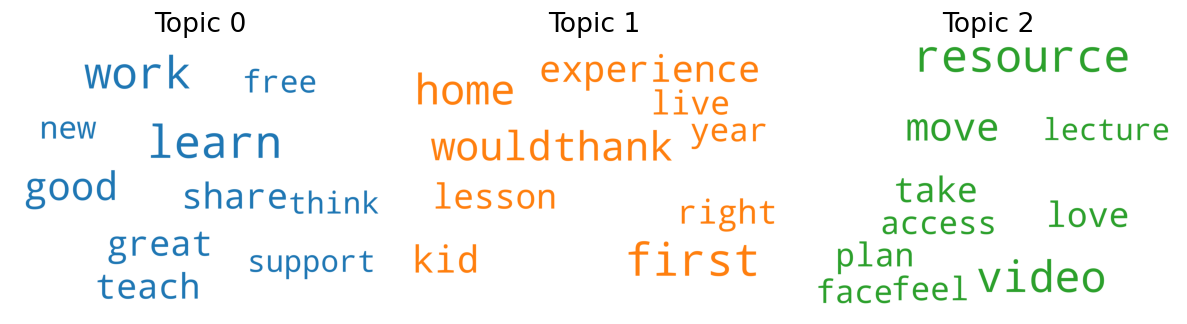

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model_pos.show_topics(formatted=False)
fig, axes = plt.subplots(1,3, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
print(topics_sorteddf_pos['Text'][39])

Great post! It influenced my philosophy. Rather than giving my Ss tons to do at home, I focused on fewer high quality assignments.


## Topic distribution across documents

In [ ]:
mytopic_dictionary={0:"Safety in taking class from home",1:"Flexibility and convenience",2:"Digital Environment tools"}
df_dominant_topic_pos["Topic_Label"]= df_dominant_topic_pos["Dominant_Topic"].map(mytopic_dictionary)

In [ ]:
#Count of each topic
df_dominant_topic_pos[["Dominant_Topic","Topic_Label"]].value_counts()

Dominant_Topic  Topic_Label                     
0.0             Safety in taking class from home    15171
1.0             Flexibility and convenience           662
2.0             Digital Environment tools             654
dtype: int64

## Running LDA - Negative Tweets

In [ ]:
copy_negative = copy.loc[copy['TextBlob_Sentiment'] == 'neg']

## Create Dictionary and Corpus needed for Topic Modeling

In [ ]:
# Create Dictionary 
id2word = gensim.corpora.Dictionary(copy_negative['clean_tweet'])  
# Create Corpus 
texts = copy_negative['clean_tweet'] 
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View copy_negative['clean_tweet']
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


Readable format of corpus can be obtained by executing below code block.

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('green', 1), ('lesson', 1), ('star', 1), ('unit', 1)]]

## Building topic model

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"learn" + 0.012*"teach" + 0.011*"bad" + 0.010*"say" + 0.010*"home" + '
  '0.010*"may" + 0.009*"feel" + 0.009*"start" + 0.008*"parent" + '
  '0.008*"remote"'),
 (1,
  '0.031*"work" + 0.018*"take" + 0.015*"think" + 0.014*"video" + 0.014*"hard" '
  '+ 0.010*"keep" + 0.009*"year" + 0.009*"ask" + 0.009*"email" + 0.009*"hour"'),
 (2,
  '0.014*"support" + 0.012*"assignment" + 0.012*"move" + 0.012*"due" + '
  '0.010*"educator" + 0.010*"lecture" + 0.010*"never" + 0.010*"offer" + '
  '0.009*"faculty" + 0.008*"late"')]


## Evaluate topic models

### Compute model Perplexity and Coherence score
Coherence score and perplexity provide a convinent way to measure how good a given topic model is.

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=copy_negative['clean_tweet'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.124290584720116

Coherence Score:  0.23804149084847917


## Visualize the topic model

In [ ]:
# feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
# lda_viz

## Optimum Number of Topics

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        print(model.log_perplexity(corpus))
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        # print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
        

    return model_list, coherence_values

In [ ]:
# Caution!!!
## This code might take 15-20 minutes to run

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=copy_negative['clean_tweet'], start=2, limit=10, step=1)


-8.011001287151169
-8.124290584720116
-8.225828135993025
-8.306831126896673
-8.382073261489845
-8.44531399732955
-8.504332830743746
-8.556389362877878


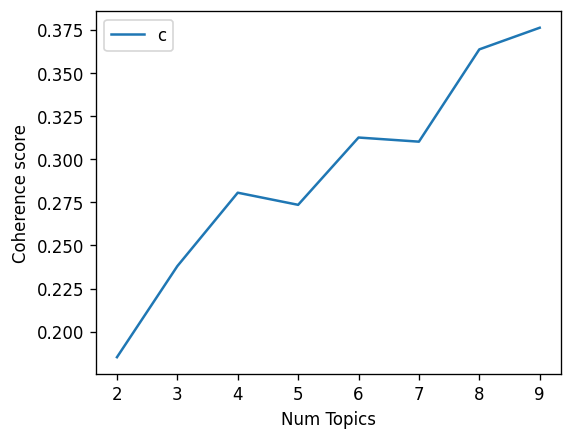

In [ ]:
limit=10; start=2; step=1
x= range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
#  Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.030*"work" + 0.025*"learn" + 0.015*"think" + 0.015*"kid" + 0.014*"teach" '
  '+ 0.012*"say" + 0.012*"home" + 0.011*"may" + 0.010*"feel" + 0.010*"parent"'),
 (1,
  '0.022*"take" + 0.021*"video" + 0.020*"hard" + 0.019*"bad" + 0.014*"ask" + '
  '0.011*"still" + 0.011*"share" + 0.011*"could" + 0.011*"less" + '
  '0.010*"access"'),
 (2,
  '0.017*"start" + 0.016*"support" + 0.014*"move" + 0.014*"hour" + '
  '0.012*"lecture" + 0.011*"never" + 0.009*"miss" + 0.009*"classroom" + '
  '0.009*"minute" + 0.009*"end"'),
 (3,
  '0.017*"keep" + 0.017*"remote" + 0.015*"assignment" + 0.015*"due" + '
  '0.013*"close" + 0.013*"educator" + 0.012*"offer" + 0.011*"faculty" + '
  '0.011*"child" + 0.010*"spend"')]


In [ ]:
# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(optimal_model, corpus, id2word)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.309290 -0.026331       1        1  36.408417
1     -0.079261  0.237581       2        1  23.653998
2     -0.126303 -0.224237       3        1  21.143823
3     -0.103726  0.012988       4        1  18.793762, topic_info=          Term        Freq       Total Category  logprob  loglift
46        work  397.000000  397.000000  Default  30.0000  30.0000
280      learn  328.000000  328.000000  Default  29.0000  29.0000
332      video  174.000000  174.000000  Default  28.0000  28.0000
85        hard  169.000000  169.000000  Default  27.0000  27.0000
139       take  228.000000  228.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
528   continue   30.943724   31.632198   Topic4  -5.3753   1.6496
205       high   31.581018   32.287904   Topic4  -5.3549   1.6495
1727    cancel   33.594014   34.379821   Topic4  -5.2931   1.6485
170      study   65.339884   71.845410   Topic4  -4.6278   1.5767
352       year   59.496894  110.211850   Topic4  -4.7215   1.0552

[163 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
365       2  0.988602      access
374       2  0.981337     already
90        2  0.993254         ask
59        4  0.995781  assignment
257       2  0.986384        back
...     ...       ...         ...
269       1  0.994936       would
308       4  0.989666       write
352       2  0.453672        year
352       4  0.535333        year
263       1  0.986729        zoom

[140 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

## Finding the dominant topic in each sentence

To find that, we find the topic number that has the highest percentage contribution in that document.

In [ ]:
def format_topics_values(ldamodel=optimal_model, corpus=corpus, texts=list(copy_negative['Tweet'])):
    value_topics_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list 
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                value_topics_df = value_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    value_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']             
    contents = pd.Series(texts)
    value_topics_df = pd.concat([value_topics_df, contents], axis=1)
    return(value_topics_df)    

df_topic_keywords = format_topics_values(ldamodel=optimal_model, corpus=corpus, texts=list(copy_negative['Tweet']))

df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Document_No','Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3446,"work, learn, think, kid, teach, say, home, may...","All Green STARS on ! Every lesson, every unit!..."
1,1,2.0,0.2938,"start, support, move, hour, lecture, never, mi...",there is a museum dedicated to failure. Displa...
2,2,1.0,0.3694,"take, video, hard, bad, ask, still, share, cou...","So, ofcourse the internet connection dies in l..."
3,3,2.0,0.4358,"start, support, move, hour, lecture, never, mi...",Just a reminder that our registrations website...
4,4,2.0,0.4140,"start, support, move, hour, lecture, never, mi...","Generally speaking, is a reasonable accommodat..."


## Find the most representative document for each topic

In [ ]:
# Group top 40 sentences under each topic
topics_sorteddf = pd.DataFrame()

topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in topics_outdf_grpd:
    topics_sorteddf = pd.concat([topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(40)], 
                                            axis=0)

# Reset Index    
topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
topics_sorteddf.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6729,"work, learn, think, kid, teach, say, home, may...",eLearning storyboards describes every single p...
1,0.0,0.6626,"work, learn, think, kid, teach, say, home, may...","While is a critical tool, it needs a lot of im..."
2,0.0,0.6597,"work, learn, think, kid, teach, say, home, may...",Do you ever feel frustrated by ? Don’t lose si...
3,0.0,0.6597,"work, learn, think, kid, teach, say, home, may...",Do you ever feel frustrated by ? Don’t lose si...
4,0.0,0.6570,"work, learn, think, kid, teach, say, home, may...",Thursday 2:30 POSCA CLUB Learn to draw and col...


## Word Clouds of Top N Keywords in Each Topic¶

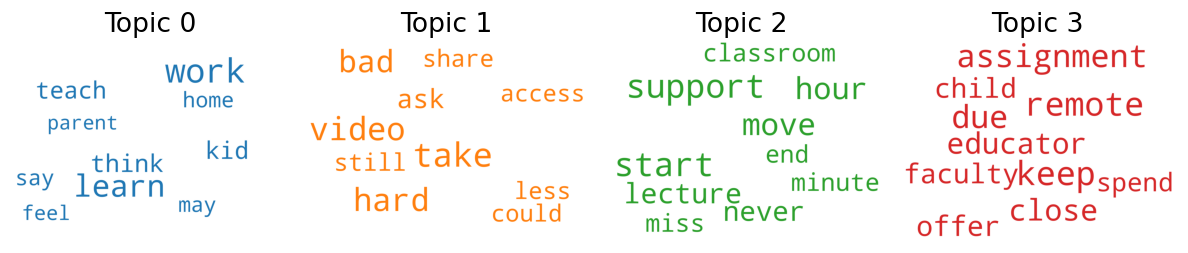

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)


topics = optimal_model.show_topics(formatted=False)
fig, axes = plt.subplots(1,4, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
print(topics_sorteddf['Text'][115])

Chatting this evening to my daughter now she's settled into her course at Uni. I was disappointed to see a sample of her lecture materials. Bullet pointed PowerPoints read out online. Seriously? I can help you do better than that.


## Topic distribution across documents

In [ ]:
mytopic_dictionary={0:"Technical Issues with digital learning tools",1:"Transition to remote Learning",2:"Workload",3:"limited support and resources"}
df_dominant_topic["Topic_Label"]= df_dominant_topic["Dominant_Topic"].map(mytopic_dictionary)

In [ ]:
#Count of each topic
df_dominant_topic[["Dominant_Topic","Topic_Label"]].value_counts()

Dominant_Topic  Topic_Label                                 
0.0             Technical Issues with digital learning tools    2548
1.0             Transition to remote Learning                    460
2.0             Workload                                         336
3.0             limited support and resources                    200
dtype: int64